# Projeto Final

Este é o projeto final da disciplina Aprendizado de Máquina (IA006-C), ministrado pelos professores Levy Boccato e Romis, na Unicamp no 2S2019.

## Projeto

A ideia do projeto é permitir a clusterização de conteúdo textual, para que a partir deste seja criado um chatbot.

Os textos passarão pro um processo de clusterização (e aqui serão apresentados duas técnicas para gerar o espaço vetorial de documentos [TF-IDF e Doc2Vec]) usando o algoritmo KMeans e usando duas métricas para cálculo das distâncias dos documentos no espaço vetorial desejado.

Posterior a isso, textos que não forem similares (ou proximamente similares aos já "classificados") serão considerados como anomalias e por conseguintes novos clusters poderão ser gerados futuramente.

In [23]:
import re
from unicodedata import normalize
from string import punctuation
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [26]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [remover_acentos(palavra.lemma_)]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [10]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)
df_data.dropna(inplace=True)
df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

,perguntas,cluster
162,não estou conseguindo acessar meu e-mail,EMAIL
21,Quanto preciso pagar para ativar meu plano pré-pago?,TELCO_ACTIVATE_PREPAID_PLAN
52,"Eu já tenho um sim da operadora, eu quero adicionar serviço de roaming internacional.",TELCO_ACTIVATE_ROAMING
104,O que vai custar menos ficar no meu plano atual ou mudar para o novo?,TELCO_CHANGE_PRICE_PLAN
200,Como atualizo minha conta para incluir chamadas internacionais?,TELCO_INTERNATIONAL_RATE_PLAN_INQUIRY
202,Quanto custa enviar uma mensagem de texto internacionalmente?,TELCO_INTERNATIONAL_RATE_PLAN_INQUIRY
201,Quanto me custará por minuto para chamar minha tia na Austrália?,TELCO_INTERNATIONAL_RATE_PLAN_INQUIRY
400,Como desligar meus dados automaticamente quando o WI-FI está disponível?,TELCO_TROUBLESHOOTING
406,Meu roteador esta com uma luz vermelha,TELCO_TROUBLESHOOTING
51,quero me conectar a rede sem fio,WIFI


In [11]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACESSO_REMOTO,20
1,CERTIFICADO,18
2,CONTA,29
3,DUVIDAS,17
4,EMAIL,40
5,LINGUAJAR,24
6,NENHUMA_OPCAO,20
7,NOME_BOT,16
8,OBRIGADO,23
9,SENHAS,27


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 696
Total cluster  : 696
X_train size   : (556,)
X_test  size   : (140,)


### Dataset tokenization

In [14]:
P = X_train.shape[0]
print("Tokenization...")
documents_d2c = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_d2c))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  556
Qtd Intents treino   :  33
Finished...


In [15]:
documents_d2c[:10]

[TaggedDocument(words=['querer', 'mudar', 'password', 'dever', 'proceder'], tags=[0]),
 TaggedDocument(words=['nao', 'nenhum', 'sinal', 'dentro', 'casar', 'existir', 'maneiro', 'corrigir'], tags=[1]),
 TaggedDocument(words=['nao', 'querer', 'mais', 'usar', 'telefonar', 'pre-pago', 'atual'], tags=[2]),
 TaggedDocument(words=['possivel', 'desativar', 'dispositivo', 'telefonar', 'pre-pago'], tags=[3]),
 TaggedDocument(words=['acesso', 'redar', 'fiar', 'departamento'], tags=[4]),
 TaggedDocument(words=['conectar', 'redar', 'fiar'], tags=[5]),
 TaggedDocument(words=['poder', 'recarregar', 'dispositivo', 'austria'], tags=[6]),
 TaggedDocument(words=['oi', 'tom', 'receber', 'novo', 'dispositivo', 'gostar', 'saber', 'poder', 'ajudar', 'desativa-lo'], tags=[7]),
 TaggedDocument(words=['precisar', 'ajudar'], tags=[8]),
 TaggedDocument(words=['favor', 'poder', 'ajudar', 'ativar', 'novo', 'telefonar', 'pre-pago', 'faze-lo', 'funcionar', 'corretamente'], tags=[9])]

### **Doc2Vec**

Parâmetros iniciais... quantidade de dimensões dos vetores gerados para cada frase, épocas de treinamento e épocas de posterior inferência para novas frases.

A quantidade de épocas de inferência, sugere-se ser bem superior as de treinamento.

In [16]:
dim = 750
epochs = 100
M = 11000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 750
Epochs       : 100
Infer Epochs : 11000


In [17]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=4, 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


Validação do modelo gerado pelo Doc2Vec... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [18]:
dc = np.c_[X_train, y_train]

acc = []
for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:75]):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    acc.append(xt[1] == y_train[sim[0][0]])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)

dc = np.c_[X_test, y_test]
accc = []
for p in range(5):
    acc = []
    for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:75]):
        new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
        sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=30))
        unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
        if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
            acc.append(xt[1] == y_train[sim[0][0].astype(np.int32)])
        else:
            acc.append(xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]])
    print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
    accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 98.67
--------------------
 - Acurácia teste 1  : 46.67
 - Acurácia teste 2  : 46.67
 - Acurácia teste 3  : 41.33
 - Acurácia teste 4  : 42.67
 - Acurácia teste 5  : 41.33
- Acurácia média teste: 43.73


### Clusterização

In [19]:
X = d2v.docvecs.vectors_docs
XT = np.array([d2v.infer_vector(tokenizer(doc), epochs=M) for doc in X_test])

In [20]:
kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [21]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.array([np.asarray(info)[:, 1]]), columns=[f"C{i}" for i in range(clusters)])

print("Frases por cluster:")
display(df.sort_values(by=["cluster"]))

print("Documentos por cluster:")
display(df_inf)

Frases por cluster:


,perguntas,cluster
0,Eu não quero mais usar meu telefone pré-pago atual.,0
14,Você pode me ajudar a aumentar meus minutos no meu telefone?,0
13,Preciso desconectar uma das minhas linhas telefônicas. Posso fazer isso por telefone?,0
12,Disseram que eu preciso trocar meu celular atual. Eles vão me pagar a taxa de rescisão mas preciso comprar o telefone ao preço total...?,0
11,Quanto preciso pagar para ativar meu plano pré-pago?,0
...,...,...
536,como acesso a rede sem fio no meu departamento,32
535,quero mudar minha password como devo proceder?,32
554,tutorial de configuração da rede sem fio no android 8,32
544,e necessario instalar algum software adicional para conectar na rede sem fio?,32


Documentos por cluster:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,15,12,21,14,20,19,26,8,18,19,15,18,9,13,21,13,26,13,15,16,29,21,14,18,21,10,13,16,22,20,14,6,21


In [39]:
lle = LocallyLinearEmbedding(
    n_components=3,
    n_neighbors=7,
    max_iter=150,
    random_state=0,
    n_jobs=-1
)
Y = lle.fit_transform(X)

kclusterer = KMeansClusterer(clusters, avoid_empty_clusters=True, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Y, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

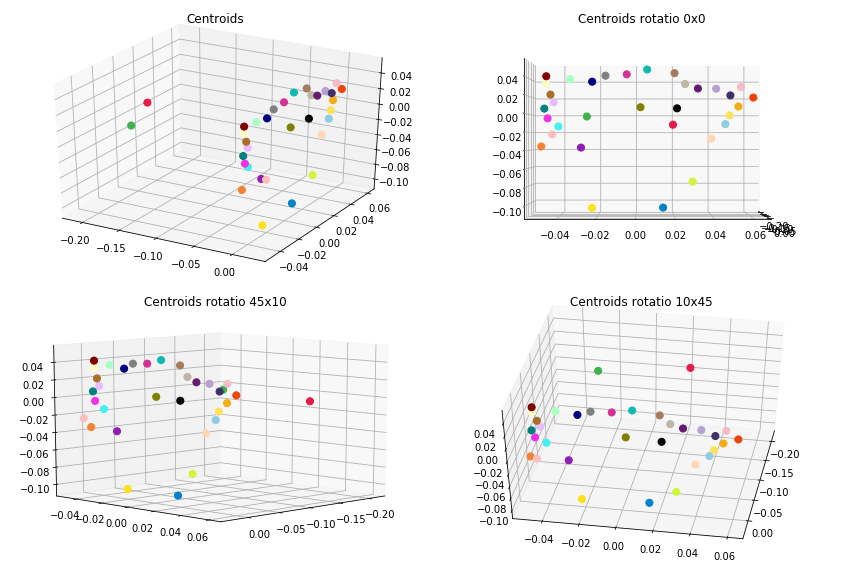

In [40]:
cnt = np.asarray(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(cnt[:, 0], cnt[:, 1], cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(cnt[:, 0], cnt[:, 1], cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(cnt[:, 0], cnt[:, 1], cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(cnt[:, 0], cnt[:, 1], cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

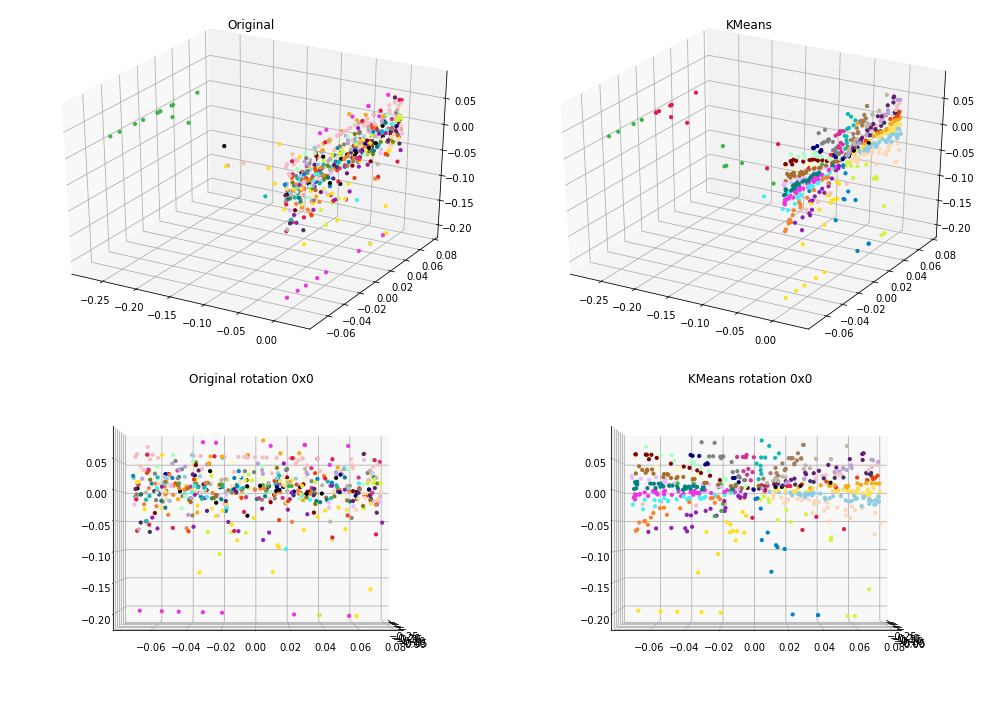

In [41]:
org_color_cluster = []
for clt in y_train:
    org_color_cluster.append(colors[clt])

color_cluster = []
for clt in assigned_clusters:
    color_cluster.append(colors[clt])

cl = (np.ones((42, 3)) * 75) / 255

plt.figure(figsize=(14, 10))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Original")
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=org_color_cluster, alpha=1, s=10)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("KMeans")
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=color_cluster, alpha=1, s=10)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Original rotation 0x0")
ax.view_init(0, 0)
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=org_color_cluster, alpha=1, s=10)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("KMeans rotation 0x0")
ax.view_init(0, 0)
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=color_cluster, alpha=1, s=10)
plt.tight_layout()
plt.show()